In [38]:
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as  sns
import xarray as xr
import random 
import geopandas as gpd
from shapely.geometry import Point
import rioxarray as rxr

from keras import layers, models, metrics
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

import fiona
fiona.supported_drivers
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.rcParams['font.family'] = 'DejaVu Sans' 

## Test Data Shaping 

In [39]:
#Load Train Arry for FeatureSelection
training_da = xr.open_dataarray("/home/jemima/Data/GRACE_ConvLSTM/training_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp_featuresel.nc", engine='netcdf4')
ref_bands = training_da.bands.to_numpy()[:-1]

#Load Test Array
test_arr = xr.open_dataarray("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp.nc",mask_and_scale=True).sel(bands=ref_bands)
test_arr

<xarray.DataArray (locs: 180, time: 178, bands: 61)>
[1954440 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2002-08-01 2002-09-01 ... 2017-05-01
  * locs     (locs) <U14 '-8.125,55.125' '-7.875,55.125' ... '-8.875,51.625'
  * bands    (bands) <U22 'Elev_mean' 'Elev_stdDev' ... 'ESoil_tavg_min'

In [40]:
window_length = 48
step_size = 1

X , times, pixelIDs = [] , [] , []
locs_list = test_arr.locs.to_numpy() 
# Loop through each pixel
for pixel_idx in range(test_arr.shape[0]):
    # For each pixel, slide over the time series with a window of size `window_length`
    # Use `step_size` to control how much you shift the window at each step
    for i in range(0, test_arr.shape[1] - window_length + 1, step_size):
        window = test_arr[pixel_idx, i:i + window_length, :]
        times.append(str(i)+':'+str(i + window_length))
        X.append(window)
        pixelIDs.append(locs_list[pixel_idx])

# Convert the list to a numpy array
X_arr = np.array(X)

# Output shape of the windowed data
print(X_arr.shape)
print(len(times))
print(len(pixelIDs))

(23580, 48, 61)
23580
23580


In [41]:
np.save("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp_featsel_windowed48.npy",X_arr)
np.save("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/processed_stacks/times_list.npy",times)
np.save("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/processed_stacks/pixel_coords.npy",pixelIDs)

## Merge Test Data and GRACE-FO Data

In [42]:
fo_da = xr.open_dataarray("/home/jemima/Data/GRACE_ConvLSTM/FO_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp.nc",mask_and_scale=True).fillna(np.nan)
test_da = xr.open_dataarray("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp.nc",mask_and_scale=True).fillna(np.nan)

merged_da = xr.concat([test_da,fo_da],dim='time').sel(bands=ref_bands)
merged_da.to_netcdf("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/FO_merged/merged.nc")

In [43]:
window_length = 48
step_size = 1

X , times, pixelIDs = [] , [] , []
locs_list = merged_da.locs.to_numpy() 
# Loop through each pixel
for pixel_idx in range(merged_da.shape[0]):
    # For each pixel, slide over the time series with a window of size `window_length`
    # Use `step_size` to control how much you shift the window at each step
    for i in range(0, merged_da.shape[1] - window_length + 1, step_size):
        window = merged_da[pixel_idx, i:i + window_length, :]
        times.append(str(i)+':'+str(i + window_length))
        X.append(window)
        pixelIDs.append(locs_list[pixel_idx])

# Convert the list to a numpy array
X_arr = np.array(X)

# Output shape of the windowed data
print(X_arr.shape)
print(len(times))
print(len(pixelIDs))

(38520, 48, 61)
38520
38520


In [44]:
np.save("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/FO_merged/LSTM_training_clean_robustnorm_naninterp_featsel_windowed48.npy",X_arr)
np.save("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/FO_merged/times_list.npy",times)
np.save("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/FO_merged/pixel_coords.npy",pixelIDs)

## Run Model

In [123]:
#Load Tuned Model
model_v = 'v7'
model = tf.keras.models.load_model('/home/jemima/Data/GRACE_ConvLSTM/models_lstm/lstm_model_'+str(model_v)+'.keras')

In [124]:
time_arr = np.load("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/FO_merged/times_list.npy")
pixelIDs = np.load("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/FO_merged/pixel_coords.npy")
X_arr = np.load("/home/jemima/Data/GRACE_ConvLSTM/test_stacks/FO_merged/LSTM_training_clean_robustnorm_naninterp_featsel_windowed48.npy")

In [125]:
predictions = model.predict(X_arr)
print(predictions.shape)

preds, times, locs = [] , [] , []
for i in range(predictions.shape[0]):
    preds.append(predictions[i,:])
    times.append(np.linspace(int(time_arr[i].split(':')[0]), int(time_arr[i].split(':')[1])-1, 48))
    locs.append(np.repeat(pixelIDs[i],48))

1204/1204 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
(38520, 48)


In [126]:
print(np.array(preds).flatten().shape)
print(np.array(times).flatten().shape)
print(np.array(locs).flatten().shape)

df_pred = pd.DataFrame(np.array(preds).flatten())
df_pred['coords'] = np.array(locs).flatten()
df_pred['timesteps'] = np.array(times).flatten()
df_pred.columns = ['TWS','coords','timesteps']
df_pred = df_pred.sort_values(['coords','timesteps'])
df_pred['timesteps'] = df_pred['timesteps'].astype(int)

df_pred_mean = pd.DataFrame(df_pred.groupby(['coords','timesteps'])['TWS'].mean())
df_pred_mean.columns = ['TWS_mean']
df_pred_std = pd.DataFrame(df_pred.groupby(['coords','timesteps'])['TWS'].std())
df_pred_std.columns = ['TWS_std']

df_pred = pd.concat([df_pred_mean,df_pred_std],axis=1)

df_pred['x'] = [str(x).split(',')[0] for x in df_pred.reset_index().coords]
df_pred['y'] = [str(x).split(',')[1] for x in df_pred.reset_index().coords]

df_pred.to_csv('/home/jemima/Data/GRACE_ConvLSTM/lstm_results/lstm_model_'+str(model_v)+'_results.csv')
df_pred = df_pred.reset_index()
df_pred

(1848960,)
(1848960,)
(1848960,)


,coords,timesteps,TWS_mean,TWS_std,x,y
0,"-10.125,51.875",0,-0.011849,NaN,-10.125,51.875
1,"-10.125,51.875",1,-0.026766,0.003635,-10.125,51.875
2,"-10.125,51.875",2,0.006905,0.005059,-10.125,51.875
3,"-10.125,51.875",3,0.019293,0.001710,-10.125,51.875
4,"-10.125,51.875",4,0.038966,0.002363,-10.125,51.875
...,...,...,...,...,...,...
46975,"-9.875,54.125",256,0.015255,0.003875,-9.875,54.125
46976,"-9.875,54.125",257,0.016007,0.007338,-9.875,54.125
46977,"-9.875,54.125",258,0.007542,0.004560,-9.875,54.125
46978,"-9.875,54.125",259,0.000450,0.007145,-9.875,54.125


In [127]:
dates = merged_da.time.to_numpy()[:-1]
df_list = []
for i in range(merged_da.shape[1]-1):
    df_pred_samp = df_pred[df_pred['timesteps'] == i]
    df_pred_samp.rename({'TWS_std':str(dates[i])[:10]},inplace=True,axis=1)
    df_pred_samp = df_pred_samp[['x','y',str(dates[i])[:10]]].set_index(['x','y'])
    df_list.append(df_pred_samp)

df_merge = pd.concat(df_list,axis=1).reset_index()

gdf_pred = gpd.GeoDataFrame(df_merge, crs="EPSG:4326", geometry=gpd.points_from_xy(df_merge.x, df_merge.y))
gdf_pred.to_file('/home/jemima/Data/GRACE_ConvLSTM/lstm_results/SHPs/lstm_model_'+str(model_v)+'_std_results.shp', driver='ESRI Shapefile')


dates = merged_da.time.to_numpy()[:-1]
df_list = []
for i in range(merged_da.shape[1]-1):
    df_pred_samp = df_pred[df_pred['timesteps'] == i]
    df_pred_samp.rename({'TWS_mean':str(dates[i])[:10]},inplace=True,axis=1)
    df_pred_samp = df_pred_samp[['x','y',str(dates[i])[:10]]].set_index(['x','y'])
    df_list.append(df_pred_samp)

df_merge = pd.concat(df_list,axis=1).reset_index()

gdf_pred = gpd.GeoDataFrame(df_merge, crs="EPSG:4326", geometry=gpd.points_from_xy(df_merge.x, df_merge.y))
gdf_pred.to_file('/home/jemima/Data/GRACE_ConvLSTM/lstm_results/SHPs/lstm_model_'+str(model_v)+'_mean_results.shp', driver='ESRI Shapefile')
gdf_pred

,x,y,2002-08-01,2002-09-01,2002-10-01,2002-11-01,2002-12-01,2003-01-01,2003-02-01,2003-03-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,geometry
0,-10.125,51.875,-0.011849,-0.026766,0.006905,0.019293,0.038966,0.032456,0.003901,0.029868,...,-0.023312,-0.001950,-0.007004,0.000066,-0.003959,0.014823,0.020805,0.013228,0.003821,POINT (-10.125 51.875)
1,-10.125,52.125,0.010714,-0.003202,0.003075,0.022099,0.030439,0.033753,0.030837,0.050459,...,-0.020487,-0.027445,-0.017397,-0.003569,0.010463,0.013174,0.016144,0.008230,0.001508,POINT (-10.125 52.125)
2,-5.875,54.375,-0.001291,-0.020228,0.005019,0.032272,0.047143,0.034699,0.034721,0.049542,...,-0.035833,-0.031858,-0.013649,-0.013640,-0.005058,-0.003435,-0.005080,0.000102,-0.009738,POINT (-5.875 54.375)
3,-5.875,54.625,0.005181,-0.009700,0.007708,0.033723,0.045670,0.036444,0.035493,0.056597,...,-0.036531,-0.044212,-0.006612,-0.000187,0.012259,0.005992,0.003011,-0.001322,-0.007572,POINT (-5.875 54.625)
4,-5.875,54.875,0.006252,-0.008583,0.004415,0.029811,0.041636,0.034755,0.032749,0.056190,...,-0.031503,-0.044649,-0.005439,0.002859,0.018763,0.008754,0.007454,0.002910,-0.000988,POINT (-5.875 54.875)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-9.875,51.875,-0.004832,-0.014348,0.003997,0.027375,0.043675,0.027871,0.017169,0.037661,...,-0.026902,-0.022719,-0.014940,-0.006507,-0.006915,0.005921,0.008731,-0.000252,-0.002386,POINT (-9.875 51.875)
176,-9.875,52.125,-0.012077,-0.027874,0.002034,0.020185,0.041769,0.031315,0.009158,0.028366,...,-0.026628,-0.019748,-0.018158,-0.005620,-0.000141,0.015654,0.013842,0.005595,-0.002298,POINT (-9.875 52.125)
177,-9.875,53.375,0.015744,0.000529,-0.004244,0.010057,0.029825,0.036206,0.027042,0.029271,...,-0.012814,-0.017014,-0.017688,0.002198,0.007934,0.012521,0.007531,0.006517,0.000549,POINT (-9.875 53.375)
178,-9.875,53.625,0.007010,-0.012156,0.006683,0.033072,0.041153,0.035540,0.028186,0.052450,...,-0.021492,-0.022957,-0.012310,-0.002204,0.007287,0.010273,0.013421,0.006527,0.002096,POINT (-9.875 53.625)


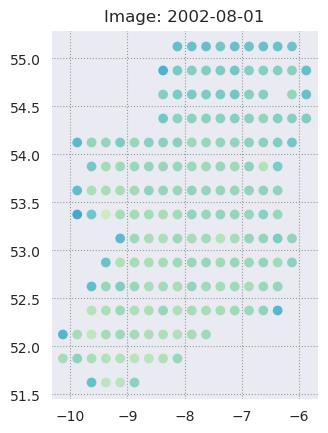

In [128]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

dateList = [str(date)[:10] for date in dates]

# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Function to update the plot for each frame (each column)
def update(frame):
    ax.clear()  # Clear the previous plot
    gdf_pred.plot(column=dateList[frame],cmap='GnBu',vmin=-0.05,vmax=0.05, ax=ax)  # Plot the current column
    ax.set_title(f"Image: {dateList[frame]}")  # Set title based on the column name

# Create the animation
ani = FuncAnimation(fig, update, frames=len(dateList), repeat=True)

# Save or display the animation
ani.save('/home/jemima/Data/GRACE_ConvLSTM/lstm_results/plots/model_'+str(model_v)+'.gif', writer='imagemagick')  # Save as a GIF